# Image Classification using Transfer Learning in TensoFlow 2.0

## #All against the COVID-19

<div align="center">
    <img src = "https://pbs.twimg.com/media/EVyYt-IU8AALA3x.jpg" 
     height = "500"
     width = "1000">
</div>

     

## <span style='color:green'> Description </span>

Face masks have become a common public sight in the last few months. The Centers for Disease Control (CDC) recently advised the use of simple cloth face coverings to slow the spread of the virus and help people who may have the virus and do not know it from transmitting it to others. Wearing masks is broadly recognised as critical to reducing community transmission and limiting touching of the face.

In a time of concerns about slowing the transmission of COVID-19, increased surveillance combined with AI solutions can improve monitoring and reduce the human effort needed to limit the spread of this disease. The objective of this challenge is to create an image classification machine learning model to accurately predict the likelihood that an image contains a person wearing a face mask, or not. The total dataset contains 1,800+ images of people either wearing masks or not.

Our machine learning solution will help policymakers, law enforcement, hospitals, and even commercial businesses ensure that masks are being worn appropriately in public. These solutions can help in the battle to reduce community transmission of COVID-19

## Import Libraries and Define functions

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import cv2
from tensorflow.python.keras import layers 
from tensorflow.python.keras import models
from keras import optimizers
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing.image import img_to_array, load_img
%tensorflow_version 2.x #to avoid loading another version at run time (since you can't change it after it's imported)
import tensorflow as tf
import os


In [0]:
def resize_images(list_of_images):
  """ Returns an Array of resized images """

  train_X = []
  NROWS=450 ; NCOLS=630
  sizes=(256,256)
  i=0
  for label in list_of_images:
    image = tf.image.resize(cv2.imread('drive/My Drive/Dauphine_Projet_Image2020/images/'+label), sizes)
    train_X.append(image)
    i+=1
    print(((i /len(list_of_images))*100)
  
  return train_X

def normalize(train_images_, test_images_):
	# convert from integers to floats
	train_norm = train_images_.astype('float32')
	test_norm = test_images_.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

#### Create a basic model made of a convolutional bloc (e.g., at least one convolutional layer followed by a maxpooling layer)
def conv_block(filter_size_, kernel_size_, max_pooling_size_, activation_type_=None, input_shape_=None): 
  model_ = tf.keras.Sequential()
  model_.add(tf.keras.layers.Conv2D(filters=filter_size_, kernel_size=kernel_size_, activation=activation_type_, input_shape=input_shape_, padding='same'))
  model_.add(tf.keras.layers.Conv2D(filters=filter_size_, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.BatchNormalization())
  model_.add(tf.keras.layers.MaxPooling2D(max_pooling_size_))
  model_.add(tf.keras.layers.Dropout(0.2))

  model_.add(tf.keras.layers.Conv2D(filters=filter_size_*2, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.Conv2D(filters=filter_size_*2, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.BatchNormalization())
  model_.add(tf.keras.layers.MaxPooling2D(max_pooling_size_))
  model_.add(tf.keras.layers.Dropout(0.3))

  model_.add(tf.keras.layers.Conv2D(filters=filter_size_*4, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.Conv2D(filters=filter_size_*4, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.Conv2D(filters=filter_size_*4, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.BatchNormalization())
  model_.add(tf.keras.layers.MaxPooling2D(max_pooling_size_))
  model_.add(tf.keras.layers.Dropout(0.4))
  return model_

##### Display the loss and metric curves  
def accuracy_lost_curves(history):
  # plot loss
  fig = plt.figure(figsize=(8,8))
  ax1 = fig.add_subplot(2,1,1)
  ax1.plot(history.history['loss'], color='blue', label='train')
  ax1.plot(history.history['val_loss'], color='orange', label='test')
  ax1.set_title('Cross Entropy Loss')
  ax1.legend(['Training Loss', 'Validation Loss'])
	# plot accuracy
  ax2 = fig.add_subplot(2,1,2)
  ax2.plot(history.history['accuracy'], color='blue', label='train')
  ax2.plot(history.history['val_accuracy'], color='orange', label='test')
  ax2.set_title('Classification Accuracy')
  ax2.legend(['Training Acc', 'Validation Acc'])
  

## Load Dataset

In [0]:
df_train_labels=pd.read_csv("/content/drive/My Drive/Dauphine_Projet_Image2020/csv/train_labels.csv")
df_sample_sub=pd.read_csv("/content/drive/My Drive/Dauphine_Projet_Image2020/csv/sample_sub_v2.csv")

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df_train_labels.head()

,image,target
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0
1,rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1
2,uuzshfrhkgrkolhwdvliqauzulurnz.jpg,0
3,mjspxsagzusaznvnyxgamtrlqkqklp.jpg,0
4,rlbmuajgezfiddjzlyeoupxpqubkpt.jpg,1


In [0]:
df_sample_sub.head()

,image,target
0,aadawlxbmapqrblgxyzarhjasgiobu.png,0
1,abpxvdfyhaaohzcrngcucmhffwizxs.jpg,0
2,aclkjfvackiieiznzfcwienplielrj.jpg,0
3,aelkivmayxgsdjosiibfgmkvfrjvjk.jpg,0
4,aelzzshpfxerelefnkatpczktuxjln.jpg,0


## Splitting the data into train and test sets

In [0]:
images_list = os.listdir('/content/drive/My Drive/Dauphine_Projet_Image2020/images')
train_labels_list = df_train_labels['image'].tolist()
test_labels_list = [label for label in images_list if label not in train_labels_list]

## Data Visualization

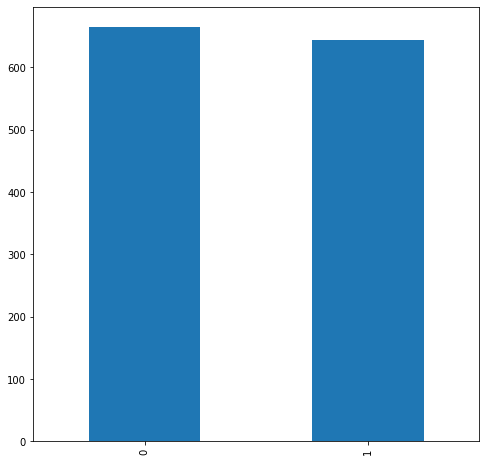

In [0]:
# Bar Pllot
df_train_labels['target'].value_counts().plot.bar(figsize=(8,8))

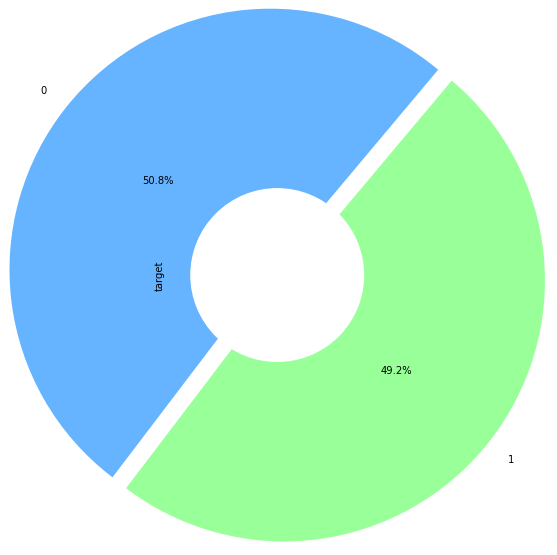

In [0]:
# Pie chart

sizes = df_train_labels['target'].value_counts()
#colors
colors = ['#66b3ff', '#99ff99']
#explsion
explode = (0.1,0.1)
 
sizes.plot.pie( colors = colors, autopct='%1.1f%%',radius=3, startangle=50, pctdistance=0.55, explode = explode)
#draw circle
centre_circle = plt.Circle((0,0),1,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

## Image Plot

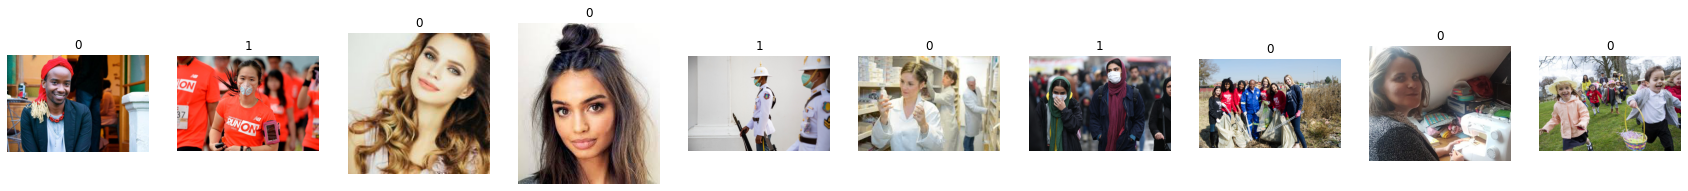

In [0]:

fig,axes = plt.subplots(1,10, figsize=(30,30))
for i in range(10):
    ax = axes[i]
    img = mpimg.imread('drive/My Drive/Dauphine_Projet_Image2020/images/'+df_train_labels['image'][i])
    ax.imshow(img)
    ax.set_title(df_train_labels['target'][i] )
    ax.axis('off')
plt.show()

In [0]:
for i in range(10):
    ax = axes[i]
    img = mpimg.imread('drive/My Drive/Dauphine_Projet_Image2020/images/'+df_train_labels['image'][i])
    print(img.shape)

(411, 600, 3)
(531, 800, 3)
(166, 166, 3)
(239, 211, 3)
(1000, 1500, 3)
(183, 275, 3)
(800, 1200, 3)
(500, 800, 3)
(482, 593, 3)
(500, 750, 3)


## Transform both train and validation Images

In [0]:
train_X = resize_images(df_train_labels['image'].tolist())

In [0]:
train_Y = df_train_labels['target'].tolist()

In [0]:
len(train_X) == len(train_Y)

True

In [0]:
len(train_Y)

1308

In [0]:
resize=True
if resize:
  import time
  start_time = time.time()
  train_X = np.array([np.array(image) for image in train_X])
  train_Y = np.array([np.array(image) for image in train_Y])
  print("--- %s seconds ---" % (time.time() - start_time))
train_Y.shape

--- 3.6998960971832275 seconds ---


(1308,)

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(train_X,train_Y, test_size=0.2,random_state=2)

In [0]:
#1-LoadData, Encode Labels and Normalize
#(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_labels_encoded = tf.keras.utils.to_categorical(y_train)
test_labels_encoded = tf.keras.utils.to_categorical(y_val)
train_images, test_images = normalize(x_train, x_val)
category_size=train_labels_encoded.shape[1]
print('Phase 1/5: DataLoaded, Encoded And Normalized')

input_shape=train_images[0].shape

Phase 1/5: DataLoaded, Encoded And Normalized


"#1-b optional - adapat input shape if you want your code to run for all datasets\nif len(train_images.shape)==4: #no need to expand, just store input shape that we'll use for the CNN\n  input_shape=train_images[0].shape\nelse: #expand both train and test image datasets\n  train_images = np.expand_dims(train_images, axis=3) \n  test_images = np.expand_dims(test_images, axis=3)\n  input_shape=train_images[0].shape\nprint('Phase 1/5 - optional: Input Shape Checked/Updated')"

In [0]:
category_size

2

## Build and Train a Baseline Model Without Data Augmentation

In [0]:
#### Instanciate your model (if you build a function to create your model)
base_model = conv_block(32, (3, 3), (2, 2), activation_type_='relu', input_shape_=input_shape)

top_layers = tf.keras.Sequential()
top_layers.add(tf.keras.layers.Flatten())
top_layers.add(tf.keras.layers.Dense(1024, activation='relu'))
top_layers.add(tf.keras.layers.Dense(512, activation='relu'))
top_layers.add(tf.keras.layers.Dense(128, activation='relu'))
top_layers.add(tf.keras.layers.Dense(32, activation='relu'))
top_layers.add(tf.keras.layers.Dense(category_size,activation='softmax'))

model= tf.keras.Sequential([
    base_model, 
    top_layers
])

model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_21 (Sequential)   (None, 32, 32, 128)       435488    
_________________________________________________________________
sequential_22 (Sequential)   (None, 2)                 134813410 
Total params: 135,248,898
Trainable params: 135,248,450
Non-trainable params: 448
_________________________________________________________________


In [0]:
#### Compile your model (use SGD optimizer and choose a relevant loss and metric)
opt = tf.keras.optimizers.SGD(lr=0.0005, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
augment_data=False
if augment_data:
  datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  it_train = datagen.flow(train_images, train_labels_encoded, batch_size=64)

In [0]:
#### Fit your model (you can use the test set as your validation data)
epochs = 100
if augment_data:
  print("Training with Augmented Data")
  steps = int(train_images.shape[0] / 64)
  history = model.fit(it_train, steps_per_epoch=steps, epochs=epochs, validation_data=(test_images, test_labels_encoded), verbose=1)
else: 
  print("Training withOUT Augmented Data")
  history = model.fit(train_images, train_labels_encoded, epochs=epochs, batch_size=64, 
                    validation_data=(test_images, test_labels_encoded))

Training withOUT Augmented Data
Epoch 1/100
17/17 [==============================] - 5s 270ms/step - loss: 0.7913 - accuracy: 0.5612 - val_loss: 0.7060 - val_accuracy: 0.4733
Epoch 2/100
17/17 [==============================] - 4s 231ms/step - loss: 0.6838 - accuracy: 0.6157 - val_loss: 0.7423 - val_accuracy: 0.4733
Epoch 3/100
17/17 [==============================] - 4s 230ms/step - loss: 0.5912 - accuracy: 0.6855 - val_loss: 0.8278 - val_accuracy: 0.4733
Epoch 4/100
17/17 [==============================] - 4s 231ms/step - loss: 0.5355 - accuracy: 0.7333 - val_loss: 0.9898 - val_accuracy: 0.4733
Epoch 5/100
17/17 [==============================] - 4s 229ms/step - loss: 0.4930 - accuracy: 0.7744 - val_loss: 1.0814 - val_accuracy: 0.4733
Epoch 6/100
17/17 [==============================] - 4s 229ms/step - loss: 0.4478 - accuracy: 0.7897 - val_loss: 1.3535 - val_accuracy: 0.4733
Epoch 7/100
17/17 [==============================] - 4s 230ms/step - loss: 0.3705 - accuracy: 0.8327 - val_los

In [0]:
# Evaluate your model via the evaluate function of a tf model
_, acc = model.evaluate(test_images, test_labels_encoded, verbose=1)
print('> %.3f' % (acc * 100.0))

9/9 [==============================] - 0s 30ms/step - loss: 1.0717 - accuracy: 0.6641
> 66.412


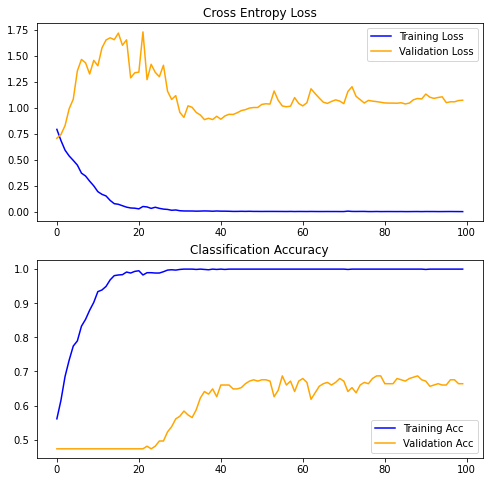

In [0]:
# Learning curves
accuracy_lost_curves(history)

## With Data Augmentation

In [0]:
#### Instanciate your model (if you build a function to create your model)
base_model = conv_block(32, (3, 3), (2, 2), activation_type_='relu', input_shape_=input_shape)

In [0]:
top_layers = tf.keras.Sequential()
top_layers.add(tf.keras.layers.Flatten())
top_layers.add(tf.keras.layers.Dense(1024, activation='relu'))
top_layers.add(tf.keras.layers.Dense(512, activation='relu'))
top_layers.add(tf.keras.layers.Dense(128, activation='relu'))
top_layers.add(tf.keras.layers.Dense(32, activation='relu'))
top_layers.add(tf.keras.layers.Dense(category_size,activation='softmax'))

model= tf.keras.Sequential([
    base_model, 
    top_layers
])

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 32, 32, 128)       435488    
_________________________________________________________________
sequential_1 (Sequential)    (None, 2)                 134813410 
Total params: 135,248,898
Trainable params: 135,248,450
Non-trainable params: 448
_________________________________________________________________


In [0]:
#### Compile your model (use SGD optimizer and choose a relevant loss and metric)
opt = tf.keras.optimizers.SGD(lr=0.0005, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
augment_data=True
if augment_data:
  datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  it_train = datagen.flow(train_images, train_labels_encoded, batch_size=64)

In [0]:
#### Fit your model (you can use the test set as your validation data)
epochs = 100
if augment_data:
  print("Training with Augmented Data")
  steps = int(train_images.shape[0] / 64)
  history = model.fit(it_train, steps_per_epoch=steps, epochs=epochs, validation_data=(test_images, test_labels_encoded), verbose=1)
else: 
  print("Training withOUT Augmented Data")
  history = model.fit(train_images, train_labels_encoded, epochs=epochs, batch_size=64, 
                    validation_data=(test_images, test_labels_encoded))

Training with Augmented Data
Epoch 1/100
16/16 [==============================] - 14s 874ms/step - loss: 0.8989 - accuracy: 0.5173 - val_loss: 0.9392 - val_accuracy: 0.5267
Epoch 2/100
16/16 [==============================] - 14s 851ms/step - loss: 0.6865 - accuracy: 0.5866 - val_loss: 1.9395 - val_accuracy: 0.5267
Epoch 3/100
16/16 [==============================] - 14s 860ms/step - loss: 0.6321 - accuracy: 0.6517 - val_loss: 2.9599 - val_accuracy: 0.5267
Epoch 4/100
16/16 [==============================] - 14s 861ms/step - loss: 0.6192 - accuracy: 0.6640 - val_loss: 3.9165 - val_accuracy: 0.5267
Epoch 5/100
16/16 [==============================] - 14s 854ms/step - loss: 0.6023 - accuracy: 0.6792 - val_loss: 4.8349 - val_accuracy: 0.5267
Epoch 6/100
16/16 [==============================] - 14s 858ms/step - loss: 0.6037 - accuracy: 0.6986 - val_loss: 5.7078 - val_accuracy: 0.5267
Epoch 7/100
16/16 [==============================] - 14s 891ms/step - loss: 0.6161 - accuracy: 0.6650 - val

In [0]:
# Evaluate your model via the evaluate function of a tf model
_, acc = model.evaluate(test_images, test_labels_encoded, verbose=1)
print('> %.3f' % (acc * 100.0))

9/9 [==============================] - 0s 30ms/step - loss: 1.2746 - accuracy: 0.6756
> 67.557


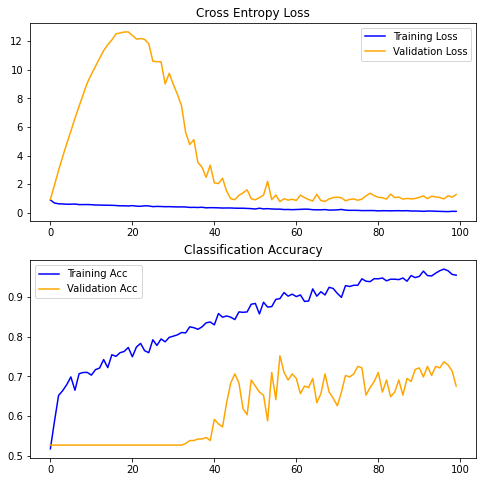

In [0]:
# Learning curves
accuracy_lost_curves(history)

## With Transfer Learning

In [0]:
base_model = tf.keras.applications.Xception(weights = 'imagenet', include_top = False, input_shape=input_shape)
base_model.trainable = True

top_layers = tf.keras.Sequential()
top_layers.add(tf.keras.layers.Flatten())
top_layers.add(tf.keras.layers.BatchNormalization())
top_layers.add(tf.keras.layers.Dropout(0.5))
top_layers.add(tf.keras.layers.Dense(category_size,activation='softmax'))

model= tf.keras.Sequential([
    base_model, 
    top_layers
])
opt = tf.keras.optimizers.SGD(lr=0.005, momentum=0.9)
#(lr=0.005, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

augment_data=True
if augment_data:
  datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.2, rotation_range=30, zoom_range=0.3, height_shift_range=0.2, horizontal_flip=True)
  it_train = datagen.flow(train_images, train_labels_encoded, batch_size=64)
  #### Fit your model (you can use the test set as your validation data)
epochs = 100
if augment_data:
  print("Training with Augmented Data")
  steps = int(train_images.shape[0] / 64)
  history = model.fit(it_train, steps_per_epoch=steps, epochs=epochs, validation_data=(test_images, test_labels_encoded), verbose=1)
else: 
  print("Training withOUT Augmented Data")
  history = model.fit(train_images, train_labels_encoded, epochs=epochs, batch_size=64, 
                    validation_data=(test_images, test_labels_encoded))

83689472/83683744 [==============================] - 1s 0us/step
Training with Augmented Data
Epoch 1/100
16/16 [==============================] - 21s 1s/step - loss: 3.2826 - accuracy: 0.7424 - val_loss: 16.3795 - val_accuracy: 0.7443
Epoch 2/100
16/16 [==============================] - 19s 1s/step - loss: 2.4983 - accuracy: 0.7312 - val_loss: 7.9196 - val_accuracy: 0.5267
Epoch 3/100
16/16 [==============================] - 19s 1s/step - loss: 0.5990 - accuracy: 0.6018 - val_loss: 3.1534 - val_accuracy: 0.5496
Epoch 4/100
16/16 [==============================] - 19s 1s/step - loss: 0.5226 - accuracy: 0.6894 - val_loss: 1.0274 - val_accuracy: 0.6221
Epoch 5/100
16/16 [==============================] - 19s 1s/step - loss: 0.4203 - accuracy: 0.7536 - val_loss: 1.3144 - val_accuracy: 0.5802
Epoch 6/100
16/16 [==============================] - 19s 1s/step - loss: 0.3807 - accuracy: 0.8177 - val_loss: 1.0598 - val_accuracy: 0.6260
Epoch 7/100
16/16 [==============================] - 19s 1s

In [0]:
model.evaluate(test_images, test_labels_encoded)

9/9 [==============================] - 1s 86ms/step - loss: 0.2911 - accuracy: 0.9656


[0.29111388325691223, 0.9656488299369812]

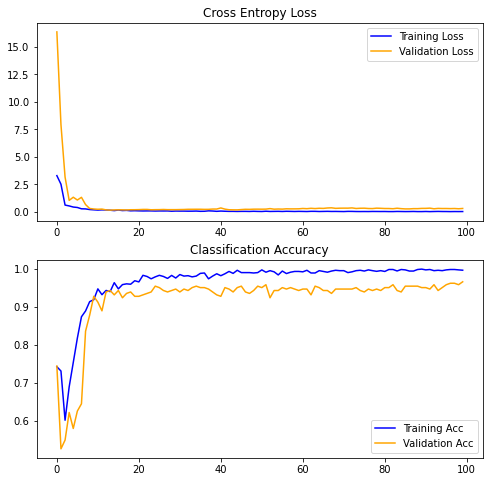

In [0]:
accuracy_lost_curves(history)

## Saving the model

In [0]:
model.save_weights('Mask_Detection_model.h5')
model.save('Mask_Detection_model.h5')

## Transfer Learning v2

In [0]:
base_model = tf.keras.applications.VGG19(weights = 'imagenet', include_top = False, input_shape=input_shape)
base_model.trainable = True

80142336/80134624 [==============================] - 1s 0us/step


In [0]:
top_layers = tf.keras.Sequential()
top_layers.add(tf.keras.layers.GlobalAveragePooling2D())
#top_layers.add(tf.keras.layers.Flatten())
top_layers.add(tf.keras.layers.Dense(128, activation='relu'))
top_layers.add(tf.keras.layers.BatchNormalization())
top_layers.add(tf.keras.layers.Dropout(0.9))
top_layers.add(tf.keras.layers.Dense(category_size,activation='softmax'))

model= tf.keras.Sequential([
    base_model, 
    top_layers
])

In [0]:
opt = tf.keras.optimizers.SGD(lr=0.0005, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
augment_data=True
if augment_data:
  datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  it_train = datagen.flow(train_images, train_labels_encoded, batch_size=64)

In [0]:
#### Fit your model (you can use the test set as your validation data)
epochs = 100
if augment_data:
  print("Training with Augmented Data")
  steps = int(train_images.shape[0] / 64)
  history = model.fit(it_train, steps_per_epoch=steps, epochs=epochs, validation_data=(test_images, test_labels_encoded), verbose=1)
else: 
  print("Training withOUT Augmented Data")
  history = model.fit(train_images, train_labels_encoded, epochs=epochs, batch_size=64, 
                    validation_data=(test_images, test_labels_encoded))

Training with Augmented Data
Epoch 1/100
16/16 [==============================] - 19s 1s/step - loss: 1.5434 - accuracy: 0.5265 - val_loss: 0.7342 - val_accuracy: 0.4733
Epoch 2/100
16/16 [==============================] - 17s 1s/step - loss: 1.3418 - accuracy: 0.5122 - val_loss: 0.6854 - val_accuracy: 0.5267
Epoch 3/100
16/16 [==============================] - 17s 1s/step - loss: 1.2308 - accuracy: 0.5305 - val_loss: 6.7991 - val_accuracy: 0.4733
Epoch 4/100
16/16 [==============================] - 17s 1s/step - loss: 1.0219 - accuracy: 0.5723 - val_loss: 9.7276 - val_accuracy: 0.4733
Epoch 5/100
16/16 [==============================] - 17s 1s/step - loss: 1.0406 - accuracy: 0.5794 - val_loss: 20.5272 - val_accuracy: 0.4733
Epoch 6/100
16/16 [==============================] - 17s 1s/step - loss: 0.9326 - accuracy: 0.5967 - val_loss: 13.1756 - val_accuracy: 0.4733
Epoch 7/100
16/16 [==============================] - 17s 1s/step - loss: 0.8557 - accuracy: 0.6039 - val_loss: 11.0441 - va

In [0]:
model.evaluate(test_images, test_labels_encoded)

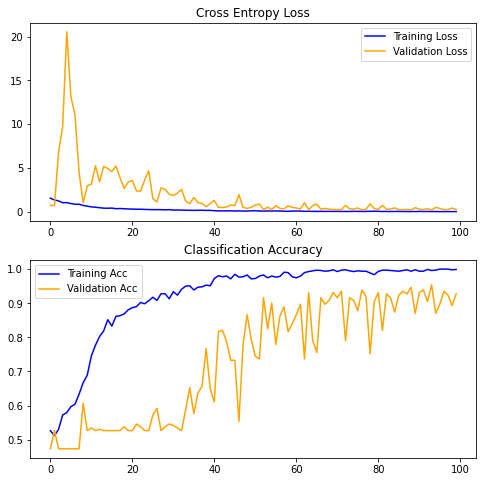

In [0]:
accuracy_lost_curves(history)

# Between the two models VGG19 and Xception, the second one is clearly more efficient!